In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import datetime as dt

## Parámetros del portafolio

In [30]:
stocks = ["KR","KO","TSLA","ORCL"]
weights = np.array([0.48,0.12,0.25,0.15])

if not np.isclose(weights.sum(),1):
    raise ValueError("Los pesos deben sumar 1")

end = dt.datetime.now()
start = end - dt.timedelta(days=365*5)

## Descarga de precios históricos

In [31]:
prices = yf.download(stocks,start=start,end=end,progress=False)["Close"]
returns = prices.pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()

print("Media diaria retornos:")
print(mean_returns)
print("\\nMatriz de covarianza:")
print(cov_matrix)

/tmp/ipython-input-2018562991.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(stocks,start=start,end=end,progress=False)["Close"]


Media diaria retornos:
Ticker
KO      0.000539
KR      0.000797
ORCL    0.001095
TSLA    0.001082
dtype: float64
\nMatriz de covarianza:
Ticker        KO        KR      ORCL      TSLA
Ticker                                        
KO      0.000100  0.000053  0.000016  0.000006
KR      0.000053  0.000282  0.000011 -0.000020
ORCL    0.000016  0.000011  0.000626  0.000243
TSLA    0.000006 -0.000020  0.000243  0.001449


In [32]:
prices.head()

Ticker,KO,KR,ORCL,TSLA
Date,,,,
2021-02-19,43.112038,30.592100,57.086021,260.433319
2021-02-22,43.559410,30.205416,60.186390,238.166672
2021-02-23,43.481987,29.701849,60.233086,232.946671
2021-02-24,43.628235,29.450062,60.419857,247.339996
2021-02-25,43.163662,29.144321,60.980160,227.406662


## Visualización de precios

Esto permite observar tendencias, volatilidad y diferencias de escala entre activos.

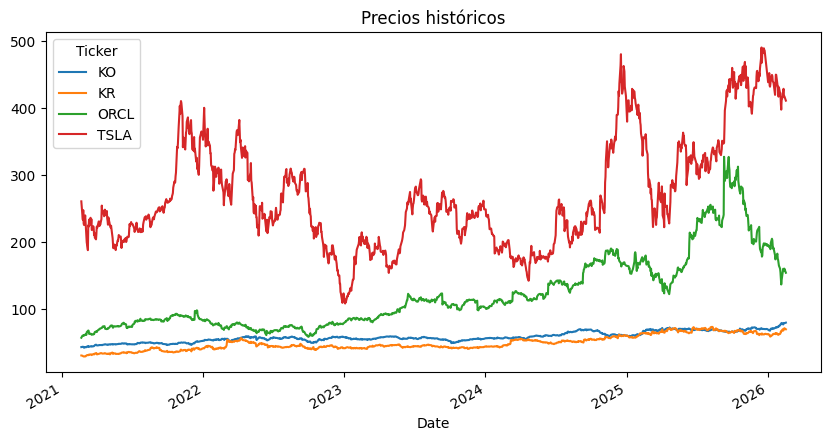

In [33]:
prices.plot(figsize=(10,5),title="Precios históricos")
plt.show()

## Correlación entre activo

La matriz de correlación muestra qué activos tienden a moverse juntos.

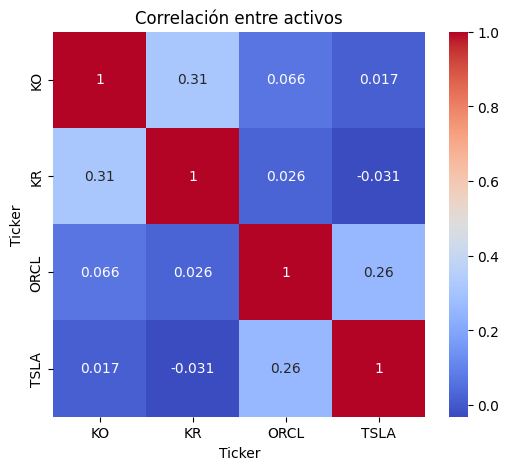

In [34]:
plt.figure(figsize=(6,5))
sns.heatmap(returns.corr(),annot=True,cmap="coolwarm")
plt.title("Correlación entre activos")
plt.show()

**Responder brevemente en comentarios dentro del código:**

**¿Qué activos están más correlacionados?**
**R=** los activoas más correlacinados son Coca Cola y Kroger con 0.28

**¿El portafolio parece estable o muy variable?**
**R =** En general parece bastante estable, más que nada por Coca Cola y Krager

**¿Cuál activo parece dominar el comportamiento del portafolio?**
**R =**  Krager pero esto se debe principalmente por que es el que tiene mayor peso.

##Retornos históricos del portafolio

Esto permite comparar el comportamiento histórico del portafolio con las simulaciones futuras.

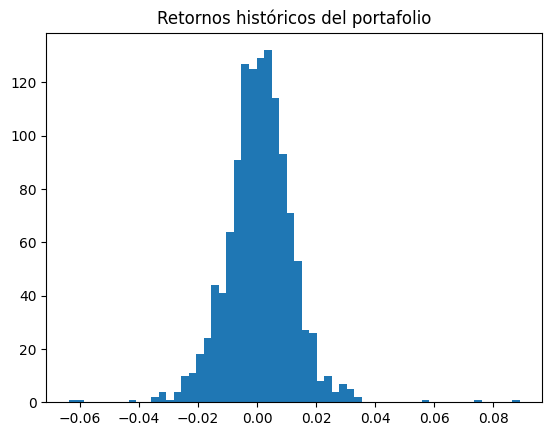

Volatilidad histórica diaria: 0.011306173971234991


In [35]:
portfolio_hist = returns.dot(weights)

plt.hist(portfolio_hist,bins=60)
plt.title("Retornos históricos del portafolio")
plt.show()

print("Volatilidad histórica diaria:", portfolio_hist.std())

#Simulación Monte Carlo multivariada

## Parámetros de simulación

La descomposición de Cholesky se utiliza para introducir la correlación entre los shocks.

In [36]:
num_sim = 5000
num_days = 252
k = len(stocks)

L = np.linalg.cholesky(cov_matrix)
portfolio_paths = np.zeros((num_days,num_sim))

## Simulación de trayectorias

Cada iteración genera una trayectoria posible del valor del portafolio.

In [37]:
for m in range(num_sim):

    Z = np.random.normal(size=(num_days,k))
    correlated = Z @ L.T
    daily_returns = correlated + mean_returns.values
    port_daily = daily_returns @ weights
    portfolio_paths[:,m] = np.cumprod(1+port_daily)

## Visualización de trayectorias

Las trayectorias muestran la incertidumbre sobre el valor futuro del portafolio.

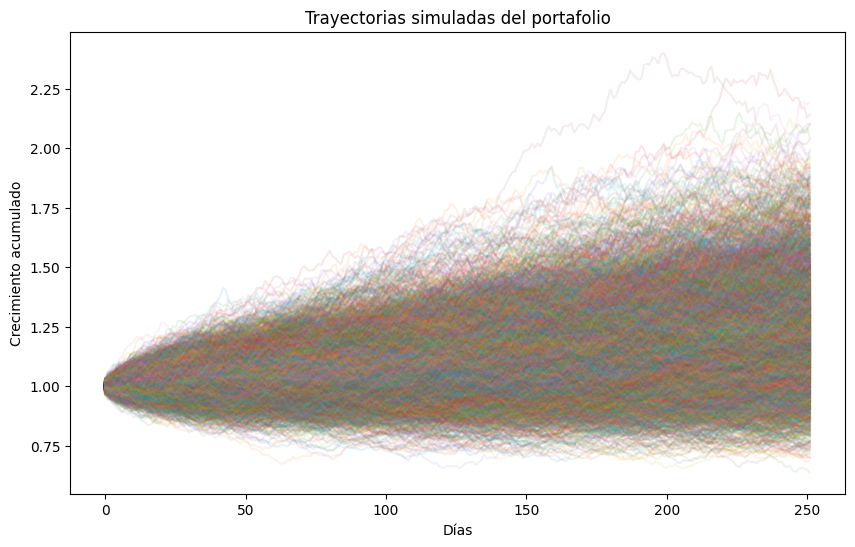

In [38]:
plt.figure(figsize=(10,6))
plt.plot(portfolio_paths,alpha=0.1)
plt.title("Trayectorias simuladas del portafolio")
plt.xlabel("Días")
plt.ylabel("Crecimiento acumulado")
plt.show()

**Responder en comentarios en Markdown:**

**¿Las trayectorias simuladas son similares entre sí o muy distintas?**
**R=** a grandes rasgos se podría decir que son similares entre sí porque todos convergen entre sí y al mismo punto.

**¿La dispersión aumenta con el tiempo?**
**R =** si bastante

**¿Qué observas en la distribución final del portafolio?**
**R =** que los valores en promedio están en 1.25 y que los valores outliers son los minimos y maximos

##  Distribución final del portafolio

Esta distribución representa todos los escenarios posibles al final del horizonte.

Cada punto del histograma corresponde a un escenario simulado.

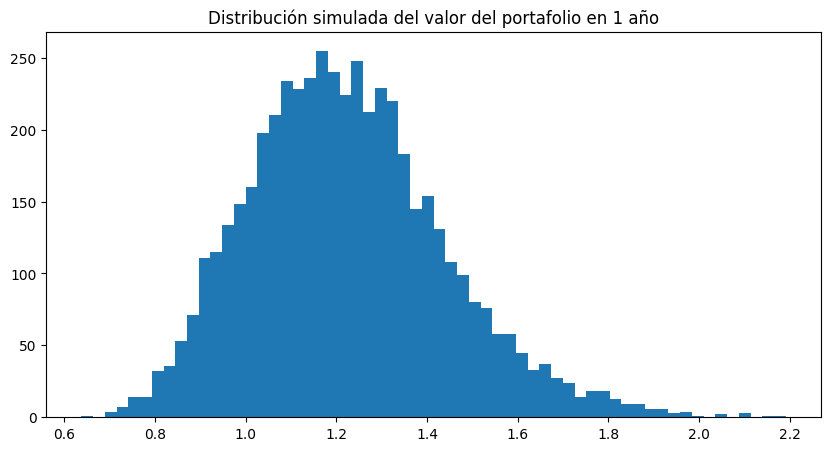

Valor esperado final: 1.2236859921154741
Probabilidad de pérdida: 0.1478


In [39]:
final_values = portfolio_paths[-1]

plt.figure(figsize=(10,5))
plt.hist(final_values,bins=60)
plt.title("Distribución simulada del valor del portafolio en 1 año")
plt.show()

print("Valor esperado final:", final_values.mean())
print("Probabilidad de pérdida:", np.mean(final_values<1))

In [40]:
print("Valor mínimo :", final_values.min())
print("Valor máximo :", final_values.max())

Valor mínimo : 0.6374490228687549
Valor máximo : 2.191742322509915


**¿Qué observas al modificar el portafolio o el horizonte?**
Se puede observar que el valor esperado del portafolio a tres años y con pesos iguales es mayor al del portafolio de cinco años, además los mínimos del portafolio a tres años se alargan más = más dispersión